### 1. 降噪 + 有效片段提取模块

In [1]:
import torch
from denoiser import pretrained
from denoiser.dsp import convert_audio
import torchaudio.transforms as T
import torchaudio
import os
from denoiser import pretrained
from denoiser.dsp import convert_audio
import matplotlib.pyplot as plt
from IPython import display as disp
import torch
import os
from speechbrain.pretrained import VAD
import torchaudio
import numpy as np
import pandas as pd
import re
import sys
sys.path.append("/mnt/zhaosheng/Voiceprint-Recognition-System-bak/test/voiceprint-recognition-system/src_gpu")
from utils.encoder import encode

VAD = VAD.from_hparams(source="speechbrain/vad-crdnn-libriparty", savedir="./nn/vad",
                            run_opts={"device":"cuda"})

plt.style.use('dark_background')

model = pretrained.dns64().cuda()

def denoise_wav(wav_data):
    wav_data = convert_audio(wav_data.cuda(), 16000, model.sample_rate, model.chin)
    with torch.no_grad():
        denoised = model(wav_data)[0]
    return denoised

def get_wavdata(wav_file):
    wav, sr = torchaudio.load(wav_file)
    print(sr)
    wav = torch.FloatTensor(wav)
    resampler = T.Resample(sr, 16000)
    wav = resampler(wav)
    return wav

def vad(wav):
    wav = torch.FloatTensor(wav).unsqueeze(0)

    print(wav.shape)
    torchaudio.save("./temp.wav", wav, 16000)
    boundaries = VAD.get_speech_segments(audio_file="./temp.wav",
                                        large_chunk_size=30,
                                        small_chunk_size=10,
                                        overlap_small_chunk=True,
                                        apply_energy_VAD=True,
                                        double_check=False,
                                        close_th=0.250,
                                        len_th=0.50,
                                        activation_th=0.5,
                                        deactivation_th=0.25,
                                        en_activation_th=0.5,
                                        en_deactivation_th=0.0,
                                        speech_th=0.50,
                                    )
    
    VAD.save_boundaries(boundaries, save_path= "./boundaries.txt" , print_boundaries=True, audio_file="./temp.wav")
    wav, sr = torchaudio.load("./temp.wav")
    
    upsampled_boundaries = VAD.upsample_boundaries(boundaries, "./temp.wav")
    print(wav.shape)
    wav = wav[0]
    print(upsampled_boundaries.shape)
    output = wav[upsampled_boundaries[0]>0.9]
    
    return output

def remove_noise_part(raw_data,denoised_data):
    diff = (denoised_data-raw_data)
    output = raw_data.copy()
    seconds = int(raw_data.shape[0]/16000)+1
    print()
    print(diff.shape)
    print(output.shape)
    for sec in range(seconds):
        print(sec)
        print(sec*16000)
        print(int((sec+0.5)*16000))
        if np.max(diff[sec*16000:int((sec+1)*16000)]) > 0.1:
            output[sec*16000:int((sec+1)*16000)] = 0
    disp.display(disp.Audio(raw_data, rate=model.sample_rate))
    disp.display(disp.Audio(denoised_data, rate=model.sample_rate))
    disp.display(disp.Audio(output, rate=model.sample_rate))
    
    vad_raw = vad(raw_data)
    vad_denoised_data = vad(denoised_data)
    vad_output = vad(output)

    disp.display(disp.Audio(vad_raw, rate=model.sample_rate))
    disp.display(disp.Audio(vad_denoised_data, rate=model.sample_rate))
    disp.display(disp.Audio(vad_output, rate=model.sample_rate))

    plt.figure(figsize=(12, 6))
    plt.subplot(1,3,1)
    plt.plot(raw_data)
    plt.subplot(1,3,2)
    plt.plot(denoised_data)
    plt.subplot(1,3,3)
    plt.plot(output)

    plt.figure(figsize=(12, 6))
    plt.subplot(1,3,1)
    plt.plot(vad_raw)
    plt.subplot(1,3,2)
    plt.plot(vad_denoised_data)
    plt.subplot(1,3,3)
    plt.plot(vad_output)

    print(encode(vad_raw))
    print(encode(vad_denoised_data))
    print(encode(vad_output))
    return output

filepath = "/mnt/zhaosheng/Voiceprint-Recognition-System-bak/test/voiceprint-recognition-system/api_test/loupan/loupan/13306218211/black_8004.wav"
wav = get_wavdata(filepath)
denoised = denoise_wav(wav)
raw_data = wav.data.cpu().numpy()[0,:]
denoised_data = denoised.data.cpu().numpy()[0,:]
remove_noise_part(raw_data,denoised_data)

16000


RuntimeError: CUDA out of memory. Tried to allocate 182.00 MiB (GPU 0; 9.78 GiB total capacity; 363.91 MiB already allocated; 130.56 MiB free; 376.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

16000

(744640,)
(744640,)
0
0
8000
1
16000
24000
2
32000
40000
3
48000
56000
4
64000
72000
5
80000
88000
6
96000
104000
7
112000
120000
8
128000
136000
9
144000
152000
10
160000
168000
11
176000
184000
12
192000
200000
13
208000
216000
14
224000
232000
15
240000
248000
16
256000
264000
17
272000
280000
18
288000
296000
19
304000
312000
20
320000
328000
21
336000
344000
22
352000
360000
23
368000
376000
24
384000
392000
25
400000
408000
26
416000
424000
27
432000
440000
28
448000
456000
29
464000
472000
30
480000
488000
31
496000
504000
32
512000
520000
33
528000
536000
34
544000
552000
35
560000
568000
36
576000
584000
37
592000
600000
38
608000
616000
39
624000
632000
40
640000
648000
41
656000
664000
42
672000
680000
43
688000
696000
44
704000
712000
45
720000
728000
46
736000
744000


torch.Size([1, 744640])
segment_001  0.00  6.65 NON_SPEECH
segment_002  6.65  10.10 SPEECH
segment_003  10.10  10.70 NON_SPEECH
segment_004  10.70  12.65 SPEECH
segment_005  12.65  13.25 NON_SPEECH
segment_006  13.25  14.90 SPEECH
segment_007  14.90  15.80 NON_SPEECH
segment_008  15.80  20.25 SPEECH
segment_009  20.25  20.75 NON_SPEECH
segment_010  20.75  23.05 SPEECH
segment_011  23.05  30.15 NON_SPEECH
segment_012  30.15  32.65 SPEECH
segment_013  32.65  33.05 NON_SPEECH
segment_014  33.05  34.90 SPEECH
segment_015  34.90  35.55 NON_SPEECH
segment_016  35.55  38.15 SPEECH
segment_017  38.15  46.54 NON_SPEECH
torch.Size([1, 744640])
torch.Size([1, 744640])
torch.Size([1, 744640])
segment_001  0.00  10.75 NON_SPEECH
segment_002  10.75  12.00 SPEECH
segment_003  12.00  13.30 NON_SPEECH
segment_004  13.30  14.60 SPEECH
segment_005  14.60  16.10 NON_SPEECH
segment_006  16.10  19.35 SPEECH
segment_007  19.35  30.15 NON_SPEECH
segment_008  30.15  32.00 SPEECH
segment_009  32.00  33.05 NON_S

KeyboardInterrupt: 

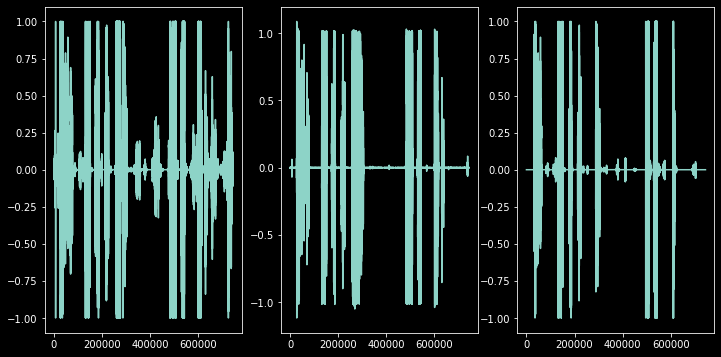

In [63]:
filepath = "/mnt/zhaosheng/Voiceprint-Recognition-System-bak/test/voiceprint-recognition-system/api_test/loupan/loupan/13306218211/black_8004.wav"
wav = get_wavdata(filepath)
denoised = denoise_wav(wav)
raw_data = wav.data.cpu().numpy()[0,:]
denoised_data = denoised.data.cpu().numpy()[0,:]
remove_noise_part(raw_data,denoised_data)